In [15]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output as clear
from game2048.game_train import Game_train
from game2048.displays import Display, IPythonDisplay
import keras
from math import log
import numpy as np
import random
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, AveragePooling2D, Input, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from collections import deque
from game2048.expectimax import board_to_move
#from game2048.expectimax import board_to_move
display1 = Display()
display2 = IPythonDisplay()
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 70074103293955705,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6741210696711642831
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4900575975091246978
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7390920704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8207786694877943087
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:08.0, compute capability: 6.1"]

In [16]:
def change_s(state):
    state = np.log2(np.maximum(np.array(state), 1)
                    ).reshape(1, 4, 4, 1)
    state = keras.utils.np_utils.to_categorical(state, 12)
    return state

def change_back_s(state):
    state = np.argmax(state, axis = -1).reshape(4, 4)
    state = 2 ** state
    state = np.where(state != 1, state, 0)
    return state

In [25]:
class DQN:
    def __init__(self):
        self.memory = deque(maxlen=2000)
        self.model_create = 0
        self.gamma = 0.9  # the discounted factor of reward
        self.epsilon = 0.1 # the ratio of randomly choose
        self.epsilon_min = 1e-3  # the min ratio of randomly choose
        self.epsilon_decay = 0.999
        self.tau = 0.8   #bigger tau will make target nearer
        
        self.model = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        self.model_create += 1

        model = Sequential()  # Has 15356 parameters to train
        model(Input(shape=(4, 4, 12)))

        model.add(Conv2D(16, (4, 4), padding='same', activation='relu'))
        model.add(Conv2D(16, (4, 4), padding='same', activation='relu'))
        model.add(Flatten())
        
        model.add(Dense(units=24, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(units=32, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(units=32, activation='relu', kernel_initializer='he_normal'))

        model.add(Dense(units=4))

        model.compile(loss='mean_squared_error',
                      optimizer='adam')

        if self.model_create == 1:
            model.summary()

        return model

    def act(self, state):
        
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            #return board_to_move(change_back_s(state))
            return np.random.randint(0, 4)
        else:
            return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 256
        if len(self.memory) < batch_size:
            return

        samples = random.sample(self.memory, batch_size)
        states = []
        targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done == 0 or done == 1:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            #elif done == 1:
                #target[0][action] = reward
            elif done == 2:
                Q_future = 10
                target[0][action] = reward + Q_future * self.gamma
            states.extend(state)
            targets.extend(target)
        self.model.fit(np.array(states), np.array(targets), batch_size = 16, epochs=10, verbose=0)
    
    def init_from_expectimax(self):
        samples = np.load("data_dqn.npy", allow_pickle=True)
        states = []
        targets = []
        Reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.001)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = np.zeros((1, 4))
            if done == 0:
                target[0][action] = int((log(np.max(state), 2) - 2)) * 0.1 + int((log(np.max(new_state), 2) - 2)) * 0.1 / ( 1 - self.gamma )
            elif done == 2:
                target[0][action] = int((log(np.max(state), 2) - 2)) * 0.1 / ( 1 - self.gamma )
            states.extend(state)
            targets.extend(target)
        return self.model.fit(np.array(states), np.array(targets), batch_size = 64, epochs=500, verbose=2, 
                             callbacks=[Reduce_lr]).history

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()

        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + \
                target_weights[i] * (1 - self.tau)

        self.target_model.set_weights(target_weights)

    def save_model(self):
        self.model.save('my_model_dqn.h5')
        
    def save_best_model(self):
        self.model.save('my_model_best_dqn.h5')
        
    def save_pre_model(self):
        self.model.save('my_model_pre_dqn.h5')
        
    def load_pre_model(self):
        self.model.load('my_model_pre_dqn.h5')

In [26]:
dqn_agent = DQN()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 4, 4, 16)          3088      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 16)          4112      
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                6168      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 4)                

In [19]:
plt.plot(dqn_agent.init_from_expectimax()['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Episode')
plt.show()

Epoch 1/500
 - 6s - loss: 0.7984
Epoch 2/500
 - 6s - loss: 0.7733
Epoch 3/500
 - 6s - loss: 0.7611
Epoch 4/500
 - 6s - loss: 0.7517
Epoch 5/500
 - 6s - loss: 0.7422
Epoch 6/500
 - 6s - loss: 0.7364
Epoch 7/500
 - 6s - loss: 0.7293
Epoch 8/500
 - 6s - loss: 0.7231
Epoch 9/500
 - 6s - loss: 0.7176
Epoch 10/500
 - 6s - loss: 0.7130
Epoch 11/500
 - 6s - loss: 0.7081
Epoch 12/500
 - 6s - loss: 0.7038
Epoch 13/500
 - 6s - loss: 0.6992
Epoch 14/500
 - 6s - loss: 0.6953
Epoch 15/500
 - 6s - loss: 0.6908
Epoch 16/500
 - 6s - loss: 0.6864
Epoch 17/500
 - 6s - loss: 0.6828
Epoch 18/500
 - 6s - loss: 0.6801
Epoch 19/500
 - 6s - loss: 0.6775
Epoch 20/500
 - 6s - loss: 0.6739
Epoch 21/500
 - 6s - loss: 0.6712
Epoch 22/500
 - 6s - loss: 0.6679
Epoch 23/500
 - 6s - loss: 0.6655
Epoch 24/500
 - 6s - loss: 0.6635
Epoch 25/500
 - 6s - loss: 0.6607
Epoch 26/500
 - 6s - loss: 0.6580
Epoch 27/500
 - 5s - loss: 0.6564
Epoch 28/500
 - 6s - loss: 0.6537
Epoch 29/500
 - 5s - loss: 0.6514
Epoch 30/500
 - 6s - lo

Epoch 213/500
 - 6s - loss: 0.5130
Epoch 214/500
 - 6s - loss: 0.5130

Epoch 00214: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
Epoch 215/500
 - 6s - loss: 0.5130
Epoch 216/500
 - 6s - loss: 0.5130
Epoch 217/500
 - 6s - loss: 0.5130
Epoch 218/500
 - 6s - loss: 0.5130
Epoch 219/500
 - 6s - loss: 0.5130

Epoch 00219: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.
Epoch 220/500
 - 6s - loss: 0.5130
Epoch 221/500
 - 6s - loss: 0.5130
Epoch 222/500
 - 6s - loss: 0.5130
Epoch 223/500
 - 6s - loss: 0.5130
Epoch 224/500
 - 6s - loss: 0.5130

Epoch 00224: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.
Epoch 225/500
 - 6s - loss: 0.5130
Epoch 226/500
 - 6s - loss: 0.5130
Epoch 227/500
 - 6s - loss: 0.5130
Epoch 228/500
 - 6s - loss: 0.5130
Epoch 229/500
 - 6s - loss: 0.5130

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.0000000664932204e-18.
Epoch 230/500
 - 6s - loss: 0.5130
Epoch 231/500
 - 6s - loss: 0.5130
Epoch 2

KeyboardInterrupt: 

In [20]:
dqn_agent.save_pre_model()

In [27]:
#dqn_agent.load_pre_model()
history_max = []
history_total = []
history = []
total_step = 0

In [28]:
from game2048.agents import Agent
import keras
from keras.models import load_model
import numpy as np

class TestAgent(Agent):

    def __init__(self, game, display=None):
        if game.size != 4:
            raise ValueError(
                "`%s` can only work with game of `size` 4." % self.__class__.__name__)
        super().__init__(game, display)
        self.model = load_model('my_model_pre_dqn.h5')
        self.epsilon = 0
        self.epsilon_min = 0

    def step(self):
        board = np.log2(np.maximum(np.array(self.game.board), 1)).reshape(1, 4, 4, 1)
        board = keras.utils.np_utils.to_categorical(board, 12)
        direction = self.model.predict_classes(board)[0]
        return direction

In [29]:
from game2048.game import Game
def single_run(size, score_to_win, AgentClass, **kwargs):
    game = Game(size, score_to_win)
    agent = AgentClass(game, display=Display(), **kwargs)
    agent.play(verbose=False)
    return game.score

N_TESTS = 20

Episode 1286 -- Max:  128, Total:  330, Steps:  110, Avg: 81.6
Now the total step is:  87964
Epsilon has reduced to:  0.00100


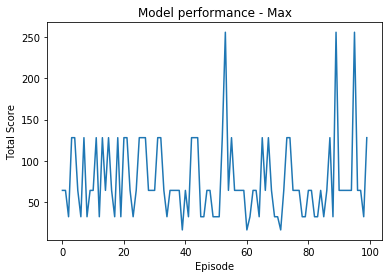

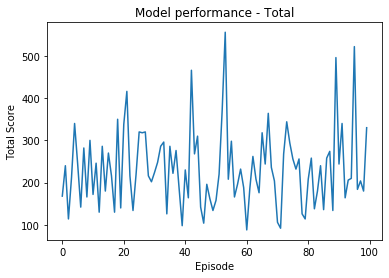

In trial 1287:


In [ ]:
trials = 100000

for trial in range(trials):

    # , score_to_win=2048
    game = Game_train(4, score_to_win=2048, random=False)
    cur_state = change_s(game.board)

    while(1):
        action = dqn_agent.act(cur_state)
        new_state, reward, done = game.move(action)

        new_state = change_s(new_state)
        dqn_agent.remember(cur_state, action, reward, new_state, done)

        #dqn_agent.replay()       # internally iterates default (prediction) model
        #dqn_agent.target_train()  # iterates target model

        cur_state = new_state

        if done:
            break
    print("In trial %4d:" % trial)
    dqn_agent.replay()
    dqn_agent.target_train()

    history_max.append(int(game.board.max()))
    history_total.append(int(game.board.sum()))
    
    total_step += game.iters
    
    if trial % 2 == 0:
        '''print('Episode %3d -- Max: %4d, Total: %4d, Steps: %4d, Avg: %.1f' % (trial,
                                                                   history_max[-1],
                                                                   history_total[-1],
                                                                   game.iters,
                                                                   round(np.mean(history[-20:]), 1)))'''
        #dqn_agent.save_model()
        '''scores = []
        for _ in range(N_TESTS):
            score = single_run(4, 2048,
                               AgentClass=TestAgent)
            scores.append(score)

        history.append(sum(scores) / N_TESTS)
        if history[-1] > np.max(history):
            dqn_agent.save_best_model()'''
        clear()
        #print('Now the total step is: %6d'% (total_step))
        #print('Epsilon has reduced to:  %.2f'%(max(dqn_agent.epsilon, dqn_agent.epsilon_min)))
        '''plt.plot(history)
        plt.title('Model performance')
        plt.ylabel('Average Score')
        plt.xlabel('Episode')
        plt.show()'''

        print('Episode %3d -- Max: %4d, Total: %4d, Steps: %4d, Avg: %.1f' % (trial,
                                                                   history_max[-1],
                                                                   history_total[-1],
                                                                   game.iters,
                                                                   round(np.mean(history_max[-20:]), 1)))
        print('Now the total step is: %6d'% (total_step))
        print('Epsilon has reduced to:  %.5f'%(max(dqn_agent.epsilon, dqn_agent.epsilon_min)))
        
        plt.plot(history_max[-100:])
        plt.title('Model performance - Max')
        plt.ylabel('Total Score')
        plt.xlabel('Episode')
        plt.show()
        
        plt.plot(history_total[-100:])
        plt.title('Model performance - Total')
        plt.ylabel('Total Score')
        plt.xlabel('Episode')
        plt.show()